## Libraries

In [17]:
# from google.colab import drive
# drive.mount('/content/drive/')


In [18]:
## Change the working dir to the project folder --- run only if needed
import os
os.getcwd()
# os.chdir('/content/drive/MyDrive/Sr.DS Assgn/')

'F:\\Sr.DS Assgn'

In [19]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import Sequential, Model
from tensorflow.keras.activations import softmax
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

#please import any required libraries
import os
from pathlib import Path
import numpy as np
import random
from shutil import copyfile
from matplotlib.image import imread
import matplotlib.pyplot as plt
from keras.layers import Dense, Activation, Flatten, Dropout, MaxPool2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.models import save_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import itertools

import keras
import cv2
# from PIL import Image, ImageOps
seed = 23
np.random.seed(seed=seed)


In [20]:
# check for GPU compatability
tf.test.gpu_device_name()


''

In [21]:
# data is in "data" folder, contains 9 classes. Needs to be organised in seperate folders before
## Preparing Data folders for train, validation, test
folders  = os.listdir('data/')
print(folders)
class_lbl = {k: v for  k, v in enumerate(folders)}
print(class_lbl)

['3_4th_driver_side_front', '3_4th_driver_side_rear', '3_4th_passenger_side_front', '3_4th_passenger_side_rear', 'driver_side', 'front', 'passenger_side', 'rear', 'test', 'train', 'unknown', 'validation']
{0: '3_4th_driver_side_front', 1: '3_4th_driver_side_rear', 2: '3_4th_passenger_side_front', 3: '3_4th_passenger_side_rear', 4: 'driver_side', 5: 'front', 6: 'passenger_side', 7: 'rear', 8: 'test', 9: 'train', 10: 'unknown', 11: 'validation'}


## Read and Analyse the Data

## ***Key Insights***
  ### Data looks inconsistent with varying sizes ((480, 640, 3) & (768, 1024, 3))
  ### It needs to be resized to common shape.
  ### Data needs to be generated using Agumentation.
  ### Should not be Fliped nor rotate more than 45.
  ### 'Unknown' class  already exists, so model can avoid Open set recognition
#  ### Built in preprocessing fuction can be used from pretrained models

data/front\31020.jpg
(768, 1024, 3)
(768, 1024, 3)
(768, 1024, 3)
(768, 1024, 3)
(480, 640, 3)
(768, 1024, 3)
(480, 640, 3)
(768, 1024, 3)
(768, 1024, 3)


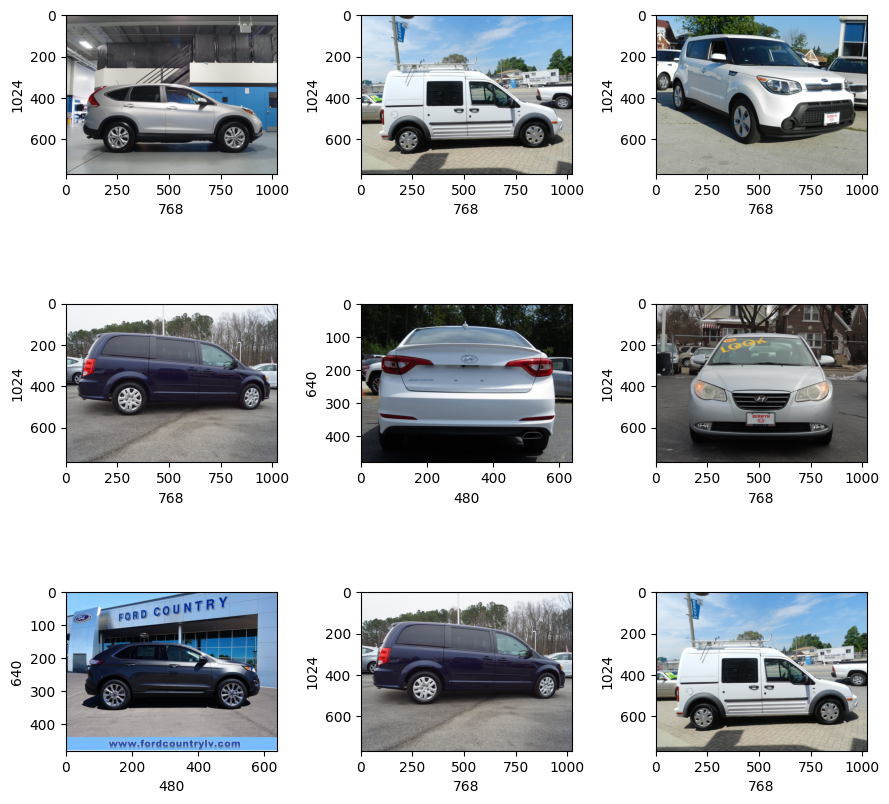

In [22]:
## Checking random images from all folders by picking randomly each time
l = []
for cls in random.sample(folders, 9):
  for f in random.sample(os.listdir(os.path.join('data/', cls)), 9):
    if f not in folders:
      l.append(os.path.join('data/', cls, f))
n = 9
num_row, num_col = 3, 3
fig, axes = plt.subplots(num_row, num_col, figsize=(3 * num_col, 3 * num_row))
print(l[random.randint(0,len(l))])
for i in range(n):
  img = imread(str(random.choice(l)))
  ax = axes[i // num_col, i % num_col]
  ax.set_xlabel(f'{img.shape[0]}')
  ax.set_ylabel(f'{img.shape[1]}')
  print(img.shape)
  ax.imshow(img)
      
plt.tight_layout()
plt.show()

## Key Points
  ### Data looks inconsistent with varying sizes ((480, 640, 3) & (768, 1024, 3))
  ### It needs to be resized to common shape.
  ### Data needs to be generated using Agumentation.
  ### Should not be Fliped nor rotate more than 45.
  ### 'Unknown' class  already exists no need to create to avoid Open set recognition problem
  ### built in preprocessing fuction can be used 


In [23]:
# Preparing data by organising into sepearate Folders
# Get all the paths
data_dir_list = os.listdir('data/')
print(data_dir_list)
path, dirs, files = next(os.walk("data/"))
file_count = len(files)
# print(file_count)


# create three folders (train, validation, test) if not exists
train_dir = os.path.join('data/', 'train')
if not os.path.isdir(train_dir):
    os.mkdir(train_dir)

validation_dir = os.path.join('data/', 'validation')
if not os.path.isdir(validation_dir):
    os.mkdir(validation_dir)

test_dir = os.path.join('data/', 'test')
if not os.path.isdir(test_dir):
    os.mkdir(test_dir)


# Under train, validation and test folders create Nine folders
# ('3_4th_driver_side_front', '3_4th_driver_side_rear', '3_4th_passenger_side_front',
#       '3_4th_passenger_side_rear', 'driver_side', 'front', 'passenger_side', 'rear', 'unknown')
data_lbls = data_dir_list

for i in data_dir_list:
    if not os.path.isdir(f'{train_dir}/{i}'):
        train_files_dir = os.path.join(train_dir, i)
        os.mkdir(train_files_dir)

for i in data_dir_list:
    if not os.path.isdir(f'{validation_dir}/{i}'):
        validation_files_dir = os.path.join(validation_dir, i)
        os.mkdir(validation_files_dir)

for i in data_dir_list:
    if not os.path.isdir(f'{test_dir}/{i}'):
        test_files_dir = os.path.join(test_dir, i)
        os.mkdir(test_files_dir)

['3_4th_driver_side_front', '3_4th_driver_side_rear', '3_4th_passenger_side_front', '3_4th_passenger_side_rear', 'driver_side', 'front', 'passenger_side', 'rear', 'test', 'train', 'unknown', 'validation']


## Splitting Data

In [24]:
# Sampling available data from each source class to train, validation and test folders that are created above
## Split data 80% training, 10% Validation, 10% testing

def split_data(SOURCE, TRAINING, VALIDATION, TEST, TRAIN_SIZE, VALID_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * TRAIN_SIZE) # 400 - 80%
    valid_length = int(len(files) * VALID_SIZE) # 50 - 10%
    test_length = int(len(files) - (training_length + valid_length)) # 50
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    valid_set = shuffled_set[training_length:(training_length+valid_length)]
    test_set = shuffled_set[(training_length+valid_length):]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in valid_set:
        this_file = SOURCE + filename
        destination = VALIDATION + filename
        copyfile(this_file, destination)

    for filename in test_set:
        this_file = SOURCE + filename
        destination = TEST + filename
        copyfile(this_file, destination)


driver_side_front_SOURCE_DIR = 'data/3_4th_driver_side_front/'
TRAINING_driver_side_front_DIR = 'data/train/3_4th_driver_side_front/'
VALID_driver_side_front_DIR = 'data/validation/3_4th_driver_side_front/'
TEST_driver_side_front_DIR = 'data/test/3_4th_driver_side_front/'

driver_side_rear_SOURCE_DIR = 'data/3_4th_driver_side_rear/'
TRAINING_driver_side_rear_DIR = 'data/train/3_4th_driver_side_rear/'
VALID_driver_side_rear_DIR = 'data/validation/3_4th_driver_side_rear/'
TEST_driver_side_rear_DIR = 'data/test/3_4th_driver_side_rear/'

passenger_side_front_SOURCE_DIR = 'data/3_4th_passenger_side_front/'
TRAINING_passenger_side_front_DIR = 'data/train/3_4th_passenger_side_front/'
VALID_passenger_side_front_DIR = 'data/validation/3_4th_passenger_side_front/'
TEST_passenger_side_front_DIR = 'data/test/3_4th_passenger_side_front/'

passenger_side_rear_SOURCE_DIR = 'data/3_4th_passenger_side_rear/'
TRAINING_passenger_side_rear_DIR = 'data/train/3_4th_passenger_side_rear/'
VALID_passenger_side_rear_DIR = 'data/validation/3_4th_passenger_side_rear/'
TEST_passenger_side_rear_DIR = 'data/test/3_4th_passenger_side_rear/'

driver_side_SOURCE_DIR = 'data/driver_side/'
TRAINING_driver_side_DIR = 'data/train/driver_side/'
VALID_driver_side_DIR = 'data/validation/driver_side/'
TEST_driver_side_DIR = 'data/test/driver_side/'

front_SOURCE_DIR = 'data/front/'
TRAINING_front_DIR = 'data/train/front/'
VALID_front_DIR = 'data/validation/front/'
TEST_front_DIR = 'data/test/front/'

passenger_side_SOURCE_DIR = 'data/passenger_side/'
TRAINING_passenger_side_DIR = 'data/train/passenger_side/'
VALID_passenger_side_DIR = 'data/validation/passenger_side/'
TEST_passenger_side_DIR = 'data/test/passenger_side/'

rear_SOURCE_DIR = 'data/rear/'
TRAINING_rear_DIR = 'data/train/rear/'
VALID_rear_DIR = 'data/validation/rear/'
TEST_rear_DIR = 'data/test/rear/'

unknown_SOURCE_DIR = 'data/unknown/'
TRAINING_unknown_DIR = 'data/train/unknown/'
VALID_unknown_DIR = 'data/validation/unknown/'
TEST_unknown_DIR = 'data/test/unknown/'

train_size = .80
valid_size = .10

split_data(driver_side_front_SOURCE_DIR, TRAINING_driver_side_front_DIR, VALID_driver_side_front_DIR, TEST_driver_side_front_DIR,
           train_size, valid_size)

split_data(driver_side_rear_SOURCE_DIR, TRAINING_driver_side_rear_DIR, VALID_driver_side_rear_DIR, TEST_driver_side_rear_DIR,
           train_size, valid_size)

split_data(passenger_side_front_SOURCE_DIR, TRAINING_passenger_side_front_DIR, VALID_passenger_side_front_DIR, TEST_passenger_side_front_DIR,
           train_size, valid_size)

split_data(passenger_side_rear_SOURCE_DIR, TRAINING_passenger_side_rear_DIR, VALID_passenger_side_rear_DIR, TEST_passenger_side_rear_DIR,
           train_size, valid_size)

split_data(driver_side_SOURCE_DIR, TRAINING_driver_side_DIR, VALID_driver_side_DIR, TEST_driver_side_DIR,
           train_size, valid_size)

split_data(front_SOURCE_DIR, TRAINING_front_DIR, VALID_front_DIR, TEST_front_DIR,
           train_size, valid_size)

split_data(passenger_side_SOURCE_DIR, TRAINING_passenger_side_DIR, VALID_passenger_side_DIR, TEST_passenger_side_DIR,
           train_size, valid_size)

split_data(rear_SOURCE_DIR, TRAINING_rear_DIR, VALID_rear_DIR, TEST_rear_DIR,
           train_size, valid_size)

split_data(unknown_SOURCE_DIR, TRAINING_unknown_DIR, VALID_unknown_DIR, TEST_unknown_DIR,
           train_size, valid_size)


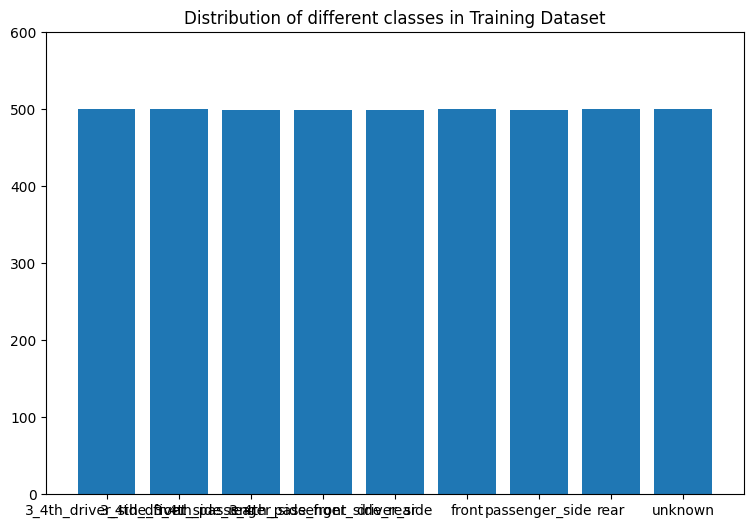

In [25]:
# Distribution of classes in train set after random splitting
image_folder = ['3_4th_driver_side_front', '3_4th_driver_side_rear',
                '3_4th_passenger_side_front', '3_4th_passenger_side_rear',
                'driver_side', 'front', 'passenger_side', 'rear', 'unknown']
nimgs = {}

for i in image_folder:
    nimages = len(os.listdir('data/train/'+i+'/'))
    nimgs[i]=nimages
plt.figure(figsize=(9, 6))
plt.bar(range(len(nimgs)), list(nimgs.values()), align='center')
plt.xticks(range(len(nimgs)), list(nimgs.keys()))
plt.title('Distribution of different classes in Training Dataset')
plt.ylim(0, 600)
plt.show()


## Define Generator initialisation

In [93]:
#  Pre-Processing & Data Augumentation
## Data Augumentation Generator
datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input,
    # rescale = 1/255.0, # No need to scale as the inceptionV3 model already scales data between (-1,1)
    rotation_range=30,
    zoom_range=0.4,
    horizontal_flip=False
    )

## Pre-Processing image by resizing as there are varying sizes as we found from above 
img_width = 224
img_height = 224
batch_size = 32 # increasing batch size will cause a problem during validation 

TRAINING_DIR = 'data/train/'
VALIDATION_DIR = 'data/validation/'
TEST_DIR = 'data/test/'

train_generator = datagen.flow_from_directory(
    TRAINING_DIR,
    batch_size=batch_size,
    class_mode='categorical',
    target_size=(img_height, img_width)
)

validation_generator = datagen.flow_from_directory(
    VALIDATION_DIR,
    batch_size=batch_size,
    class_mode='categorical',
    target_size=(img_height, img_width)
)

test_generator = datagen.flow_from_directory(
    TEST_DIR,
    batch_size=batch_size,
    class_mode='categorical',
    target_size=(img_height, img_width)
)



Found 4496 images belonging to 9 classes.
Found 1856 images belonging to 9 classes.
Found 1840 images belonging to 9 classes.


### **Visualization After Transformation**

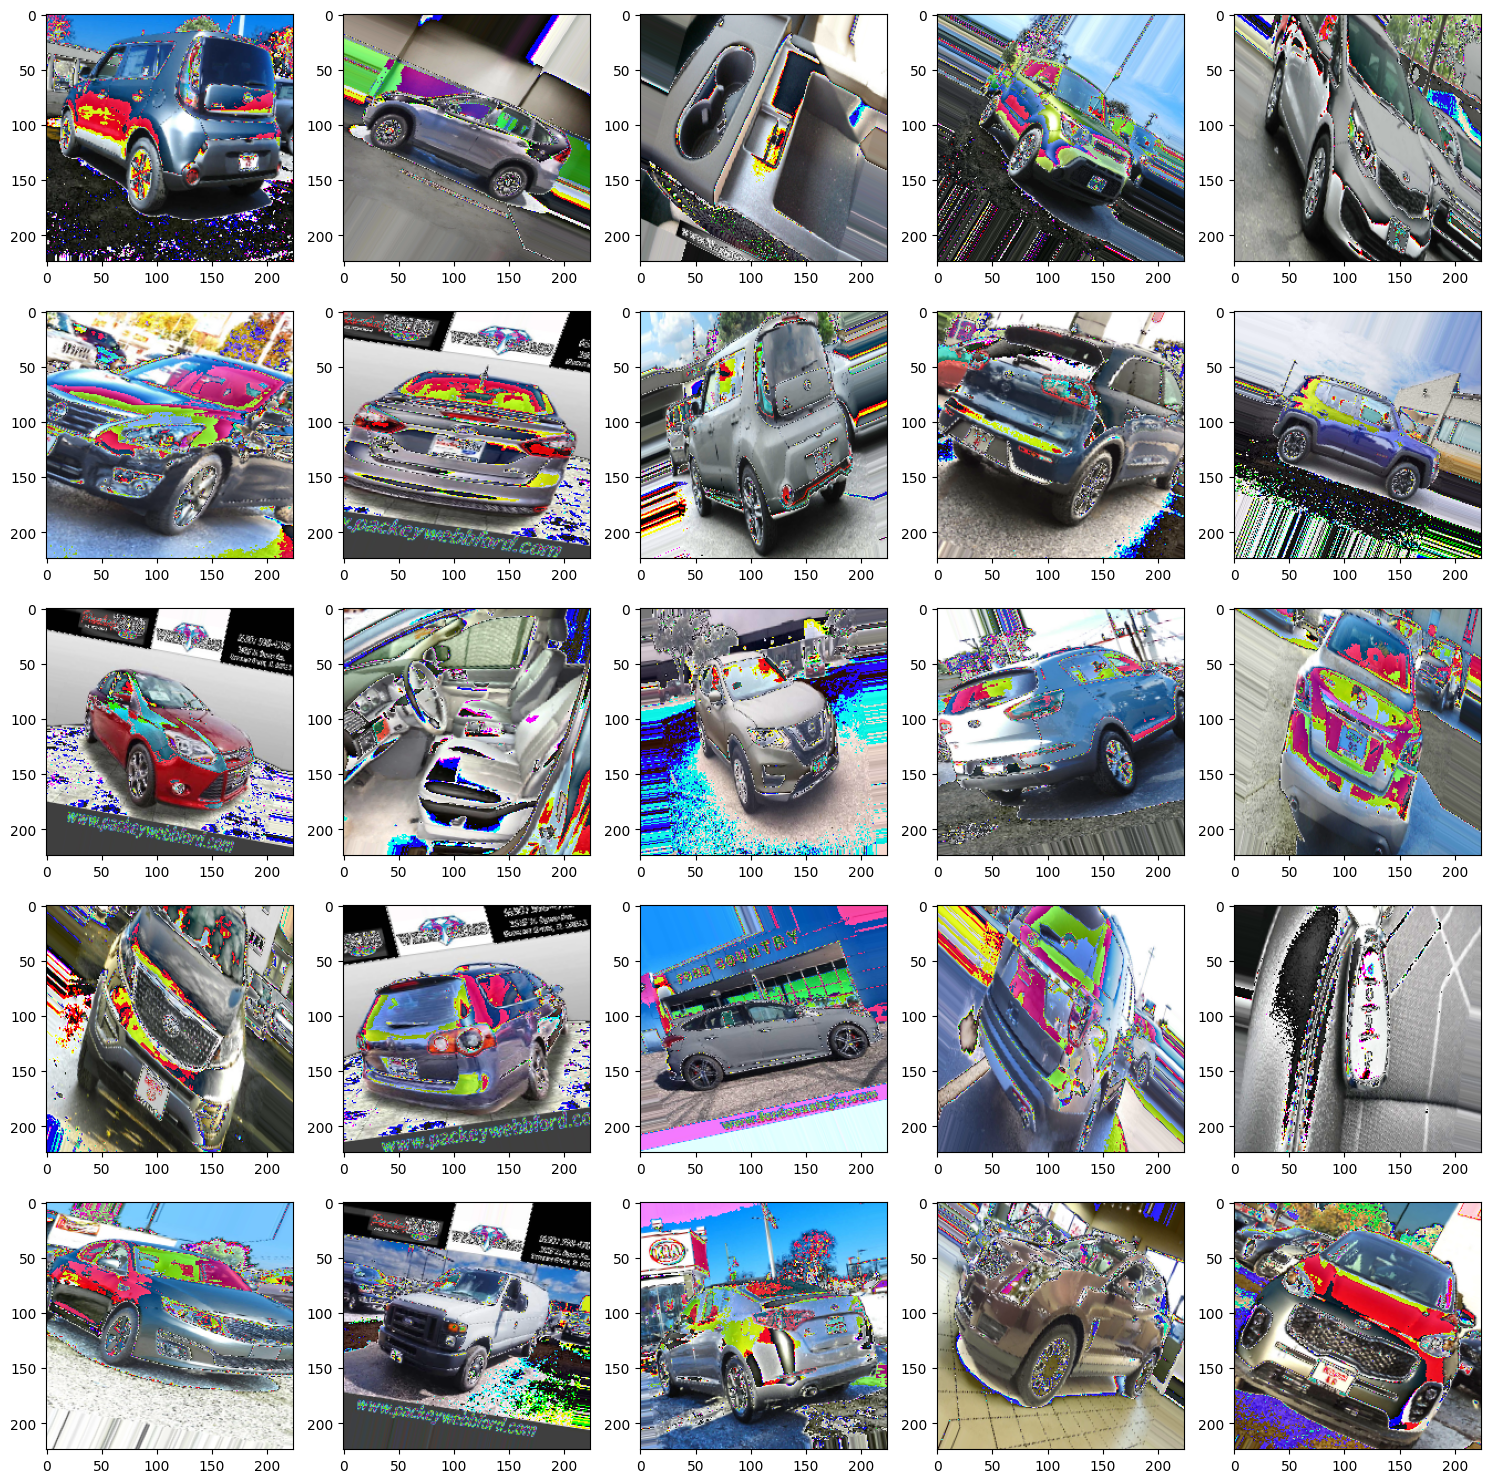

In [15]:
## Visualize First batch of train data
first_batch = train_generator.next()
# first_batch[0][0]
def visualize_batch(batch: tf.keras.preprocessing.image.DirectoryIterator):
    """Visualize a batch of train data
    
    Args:
        batch: tf.keras.preprocessing.image.DirectoryIterator
        
    Returns:
        Plot """
    
    n = 25
    num_row, num_col = 5, 5
    fig, axes = plt.subplots(num_row, num_col, figsize=(3 * num_col, 3 * num_row))
    
    for i in range(n):
        img = np.array(batch[0][i] * 255, dtype='uint8')
        ax = axes[i // num_col, i % num_col]
        ax.imshow(img)
        
    plt.tight_layout()
    plt.show()
    
    
visualize_batch(batch=first_batch)

## Defining Base Model (Trained models)

In [ ]:
# add Fully connected last layers( as many as you like to improve the performance), 
#try-out drop-out in Fully connected layers if you think it is necessary
def add_last_layer(model, n_classes, fc_layer_size):
    
    ## Add your code here
    return Model

def add_new_last_layer(base_model, n_classes, fc_layer_size):
    """Add last layer to the convnet
    
    Args:
        base_model: keras model excluding top
        nb_classes: # of classes
        
    Returns:
        new keras model with last layer
    """
    base_model_output = base_model.output
    # x = MaxPooling2D()(base_model_output)
    x = Dropout(0.4)(base_model_output)
    model_flat = Flatten()(base_model_output)
    predictions = Dense(n_classes, activation='softmax', name='predictions')(model_flat)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model 

model = InceptionV3(input_shape = (224, 224, 3), weights='imagenet', include_top=False)
# model.summary()
for i in model.layers:
  i.trainable=False
model = add_new_last_layer(model, n_classes=9, fc_layer_size= (224, 224, 3))

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_282 (Conv2D)            (None, 111, 111, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_282 (Batch  (None, 111, 111, 32  96         ['conv2d_282[0][0]']             
 Normalization)                 )                                                           

## Compiling Model

In [ ]:
#Add callbacks like early stopping, cyclical or variable learning rate or anyting you feel necessary
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)
lr_schedule
opt = Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=5e-04)
model_path = '/content/drive/MyDrive/Sr.DS Assgn/model'
log_dir = '/content/drive/MyDrive/Sr.DS Assgn/logs'
top_weights_path = os.path.join(os.path.abspath(model_path), 'top_model_weights.h5')
callbacks_list = [
        ModelCheckpoint(top_weights_path, monitor='val_accuracy', verbose=1, save_best_only=True),
        EarlyStopping(monitor='val_accuracy', patience=5, verbose=0),
        keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=False, write_images=False)
    ]
##add Code Here
##add model compile code here
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])

## Training

In [ ]:
## Freeze some layers first and then train the unfrozen layers it. (experiment with number of layers to freeze for best metrics)

## Next train all the layers
train_samples = 3600  # 400*9 classes
history_tl = model.fit_generator(train_generator,
                        steps_per_epoch=train_samples // batch_size,
                        epochs= int(50 / 5),
                        validation_data=validation_generator,
                        validation_steps= int(450 // batch_size),
                        callbacks=callbacks_list
                        )


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/10
112/112 [==============================] - ETA: 0s - loss: 0.8588 - accuracy: 0.9207
Epoch 1: val_accuracy improved from -inf to 0.82589, saving model to /content/drive/MyDrive/Sr.DS Assgn/model/top_model_weights.h5
112/112 [==============================] - 1323s 12s/step - loss: 0.8588 - accuracy: 0.9207 - val_loss: 4.0502 - val_accuracy: 0.8259
Epoch 2/10
112/112 [==============================] - ETA: 0s - loss: 1.0844 - accuracy: 0.9159
Epoch 2: val_accuracy improved from 0.82589 to 0.90179, saving model to /content/drive/MyDrive/Sr.DS Assgn/model/top_model_weights.h5
112/112 [==============================] - 445s 4s/step - loss: 1.0844 - accuracy: 0.9159 - val_loss: 2.8561 - val_accuracy: 0.9018
Epoch 3/10
112/112 [==============================] - ETA: 0s - loss: 0.6303 - accuracy: 0.9493
Epoch 3: val_accuracy improved from 0.90179 to 0.91518, saving model to /content/drive/MyDrive/Sr.DS Assgn/model/top_model_weights.h5
112/112 [==============================] - 491s

In [ ]:
model.save('model/model_optimized')

In [27]:
model = keras.models.load_model('model/model_optimized')


In [133]:
# model.save_weights('model/model_weights')
model.load_weights()

In [30]:
model2=model

model2.load_weights('model/top_model_weights.h5')


### **Train History Diagnostics**

In [11]:
import json
history_dict = json.load(open('model/optimized_history', 'r'))
history_dict


{'loss': [0.8587548136711121,
  1.084426999092102,
  0.6303180456161499,
  0.5048826336860657,
  0.6722763776779175,
  0.7105345726013184,
  0.7584700584411621,
  0.5008837580680847,
  0.8343987464904785],
 'accuracy': [0.9206838607788086,
  0.915919303894043,
  0.9492713212966919,
  0.9618834257125854,
  0.9453475475311279,
  0.9456278085708618,
  0.9431053996086121,
  0.9672085046768188,
  0.9442264437675476],
 'val_loss': [4.050198554992676,
  2.8561432361602783,
  1.7176264524459839,
  1.4856244325637817,
  2.1230716705322266,
  2.6655383110046387,
  2.2390761375427246,
  2.646967649459839,
  4.249618053436279],
 'val_accuracy': [0.8258928656578064,
  0.9017857313156128,
  0.9151785969734192,
  0.9263392686843872,
  0.90625,
  0.9040178656578064,
  0.921875,
  0.9151785969734192,
  0.8928571343421936]}

In [16]:
from matplotlib import rcParams
import pandas as pd

initial_history = dict('history':history_dict)
initial_history.history = history_dict
print(initial_history.history)
# rcParams['figure.figsize'] = (18, 8)
# rcParams['axes.spines.top'] = False
# rcParams['axes.spines.right'] = False 
# print(initial_history.history.keys())
# plt.plot(
#     np.arange(1, len(initial_history.history['accuracy'])+1), 
#     initial_history.history['loss'], 
#     label='Loss', lw=3
# )
# plt.plot(
#     np.arange(1, len(initial_history.history['accuracy'])+1), 
#     initial_history.history['accuracy'], 
#     label='Accuracy', lw=3
# )
# plt.plot(
#     np.arange(1, len(initial_history.history['val_accuracy'])+1), 
#     initial_history.history['val_accuracy'], 
#     label='validation accuracy', color='#000', lw=3, linestyle='--'
# )
# plt.title('Evaluation metrics', size=20)
# plt.xlabel('Epoch', size=14)
# plt.legend();

# ### We can see that the Accuracy and val_accuracy are close to each other but they are constant over epochs 
# ### Which implies there is a need of improvement on learning rate 
# ### Cannot decide with only 10 epochs  

SyntaxError: invalid syntax (2722420282.py, line 4)

## Testing

In [94]:
## Test data preprocessing (With same preprocessing function from train & validation)
test_generator
# Picking the best model weights for testing
# top_weights_path = os.path.join('model/', 'top_model_weights.h5')
pred = model.evaluate(test_generator,verbose=1, steps=32)
pred

58/58 [==============================] - 58s 989ms/step - loss: 0.5347 - accuracy: 0.9527


[0.5346671938896179, 0.9527173638343811]

In [97]:
pred2 = model2.predict_generator(test_generator,verbose=1,steps=32)
pred2

c:\users\python\python37\lib\site-packages\ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


32/32 [==============================] - 32s 978ms/step


array([[1.0000000e+00, 0.0000000e+00, 1.0216300e-32, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [4.3310472e-14, 3.9523720e-10, 1.0000000e+00, ..., 7.1540208e-22,
        1.1724374e-29, 6.9868492e-32],
       [3.5475159e-21, 3.4306952e-27, 0.0000000e+00, ..., 7.3228111e-36,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 5.9686049e-32, 0.0000000e+00, ..., 4.9250385e-33,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 7.0404731e-30, 0.0000000e+00, ..., 1.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [2.4234579e-16, 1.0266604e-26, 2.1601149e-27, ..., 9.9999928e-01,
        0.0000000e+00, 2.7227185e-32]], dtype=float32)

In [123]:
test_imgs, test_labels = next(test_generator)
predictions = model.predict(x=test_generator, steps=len(test_generator), verbose=1)
#---complete set of predictions of the test images 
predictions2 = model2.predict(x=test_generator, steps=len(test_generator), verbose=1)
#---complete set of predictions of the test images 

58/58 [==============================] - 62s 1s/step


In [121]:
t_labels =  np.concatenate([np.argmax(test_generator[i][1], axis=1) for i in range(n_batches)])


In [134]:
predictions.argmax(axis=1).shape
# len(t_labels)
len(test_generator)
(t_labels)
test_generator.class_indices
# 32*58
# 1840/58


{'3_4th_driver_side_front': 0,
 '3_4th_driver_side_rear': 1,
 '3_4th_passenger_side_front': 2,
 '3_4th_passenger_side_rear': 3,
 'driver_side': 4,
 'front': 5,
 'passenger_side': 6,
 'rear': 7,
 'unknown': 8}

In [96]:
## Checking model performance on a batch(32) of test images
loss, acc = model.evaluate(test_generator, steps=1)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

58/58 [==============================] - 60s 1s/step - loss: 0.4398 - accuracy: 0.9603
Restored model, accuracy: 96.03%


In [111]:
loss, acc = model.evaluate(test_generator,verbose=1, steps=58)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

58/58 [==============================] - 63s 1s/step - loss: 0.4716 - accuracy: 0.9587
Restored model, accuracy: 95.87%


In [124]:
n_batches = len(test_generator)

confusion_matrix(
    np.concatenate([np.argmax(test_generator[i][1], axis=1) for i in range(n_batches)]),    
    np.argmax(model.predict_generator(test_generator, steps=n_batches), axis=1) 
)


KeyboardInterrupt: 

In [130]:
## Checking model performance on a complete test sample (450)
# cm = confusion_matrix(test_generator.classes, predictions.argmax(axis=1))
cm = confusion_matrix(y_true=t_labels, y_pred=predictions.argmax(axis=1))
print(cm)
cm2 = confusion_matrix(y_true=t_labels, y_pred=predictions2.argmax(axis=1))
cm2

[[205   0   0   2   0   1   0   0   0]
 [  0 198   1  10   0   0   0   0   0]
 [  2   0 199   0   0   0   1   0   0]
 [  4   0   0 203   0   0   0   0   0]
 [  0   0   0   0 200   0   4   0   0]
 [  0   0   0   4   0 199   0   1   2]
 [  0   0   0   1  19   0 182   0   0]
 [  0   0   0   6   1   3   0 183   6]
 [  0   0   1   0   0   0   0   0 202]]


array([[26, 27, 19, 28, 24, 27, 20, 21, 16],
       [33, 24, 22, 18, 26, 19, 26, 18, 23],
       [18, 13, 28, 27, 22, 21, 25, 28, 20],
       [20, 22, 22, 32, 17, 23, 26, 25, 20],
       [32, 21, 26, 18, 24, 29, 15, 19, 20],
       [20, 21, 22, 26, 22, 23, 20, 21, 31],
       [12, 25, 25, 22, 29, 21, 19, 16, 33],
       [23, 20, 22, 23, 28, 19, 19, 20, 25],
       [22, 28, 18, 28, 23, 18, 21, 25, 20]], dtype=int64)

In [105]:
rep = classification_report(t_labels, predictions.argmax(axis=1),
                            target_names=list(test_generator.class_indices.keys()))
print(rep)

                            precision    recall  f1-score   support

   3_4th_driver_side_front       0.15      0.15      0.15       208
    3_4th_driver_side_rear       0.13      0.12      0.13       209
3_4th_passenger_side_front       0.14      0.13      0.14       202
 3_4th_passenger_side_rear       0.13      0.14      0.14       207
               driver_side       0.13      0.14      0.13       204
                     front       0.13      0.13      0.13       206
            passenger_side       0.11      0.10      0.11       202
                      rear       0.13      0.13      0.13       199
                   unknown       0.10      0.10      0.10       203

                  accuracy                           0.13      1840
                 macro avg       0.13      0.13      0.13      1840
              weighted avg       0.13      0.13      0.13      1840



In [174]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    

Confusion matrix, without normalization
[[49  0  0  1  0  0  0  0  0]
 [ 0 49  0  0  0  0  0  1  0]
 [ 0  5 45  0  0  0  0  0  0]
 [ 2  3  0 44  0  0  1  0  0]
 [ 0  0  0  0 48  0  2  0  0]
 [ 0  1  0  0  0 46  0  3  0]
 [ 0  1  0  0  2  0 46  1  0]
 [ 0  0  0  0  0  1  0 49  0]
 [ 0  0  1  0  0  0  0  2 47]]


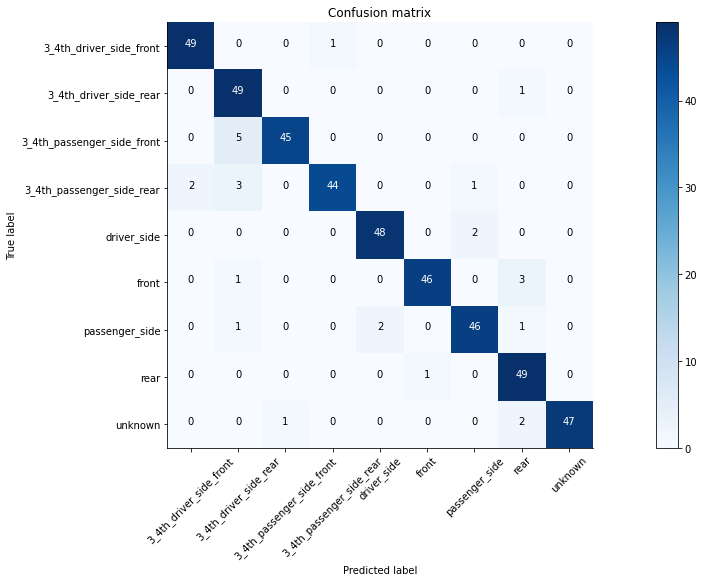

In [179]:
plot_confusion_matrix(cm, list(test_generator.class_indices.keys()),
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Green)

In [23]:
## Test data preprocessing (With same preprocessing function from train & validation)
datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input,
    # rescale = 1/255.0, # No need to scale as the inceptionV3 model already scales data between (-1,1)
    rotation_range=10,
    zoom_range=0.4,
    horizontal_flip=False
    )


TEST_DIR = 'data/test/'
test_generator = datagen.flow_from_directory(
    TEST_DIR,
    batch_size=32,
    class_mode='categorical',
    target_size=(224, 224), shuffle=False #--consistent predictions
)


Found 865 images belonging to 9 classes.


In [19]:
# for cls in os.listdir('data/test/'):
#     print(cls)

P = []
for i in range(9):
    p = 'data/test/'
    cls = random.choice(os.listdir('data/test/'))
    p += (cls) + '/'
    print(p)
    file = random.choice(os.listdir(p))
    p += (file)
    P.append(p)
print(P)

data/test/rear/
data/test/3_4th_driver_side_front/
data/test/3_4th_driver_side_front/
data/test/3_4th_driver_side_front/
data/test/driver_side/
data/test/passenger_side/
data/test/front/
data/test/3_4th_driver_side_front/
data/test/rear/
['data/test/rear/80383.jpg', 'data/test/3_4th_driver_side_front/22335.jpg', 'data/test/3_4th_driver_side_front/55920.jpg', 'data/test/3_4th_driver_side_front/79957.jpg', 'data/test/driver_side/5102.jpg', 'data/test/passenger_side/191627.jpg', 'data/test/front/10153.jpg', 'data/test/3_4th_driver_side_front/33697.jpg', 'data/test/rear/9008.jpg']


(768, 1024, 3)
(768, 1024, 3)
(768, 1024, 3)
(768, 1024, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(768, 1024, 3)
(480, 640, 3)


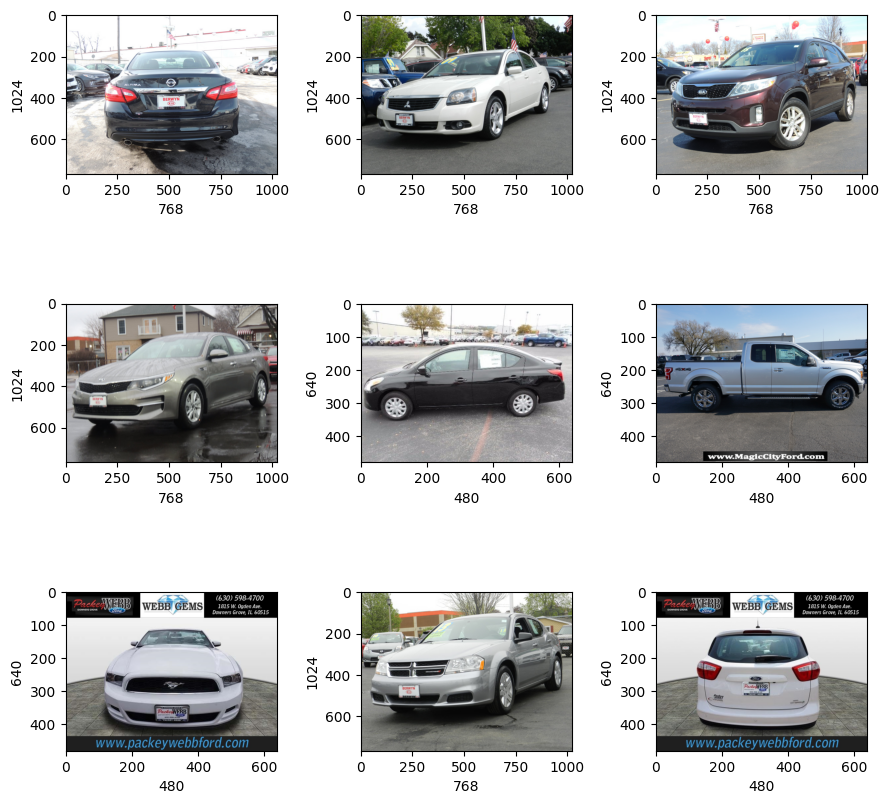

In [20]:
n = 9
num_row, num_col = 3, 3
fig, axes = plt.subplots(num_row, num_col, figsize=(3 * num_col, 3 * num_row))

for i in range(n):
  img = imread(P[i])
  ax = axes[i // num_col, i % num_col]
  ax.set_xlabel(f'{img.shape[0]}')
  ax.set_ylabel(f'{img.shape[1]}')
  print(img.shape)
  ax.imshow(img)
      
plt.tight_layout()
plt.show()


## Improving Model

## **Thoughts on improving the model accuracy**

In [ ]:
#Please add your thoughts on way to improve the model.
## Can experiment more with Data Agumentation by using different set of built in functions and parameters(Distortion etc)
## Combination of Learning rate schedules can be adopted 
## Can try more epochs, more than 10
## regularization techniques like weight decay can be adjusted according to loss function

## You can train the model with previous weights by freezing the base layers and unfreezing top again

In [182]:
 # Fine-tuning by  freezing the base layers and unfreezing the top layers of the model
print("\nStarting to Fine Tune Model\n")
base_model_block_layer_number = 126
train_samples = 3600  # 400*9 classes
validation_samples = 450
# add the best weights from the train top model
model_path = '/content/drive/MyDrive/Sr.DS Assgn/model'
top_weights_path = os.path.join(os.path.abspath(model_path), 'top_model_weights.h5')
model.load_weights(top_weights_path)

# last_block_layer_number points to the layer in your model you want to train.
# will be re-trained based on the new data.
for layer in model.layers[:base_model_block_layer_number]:
    layer.trainable = False
for layer in model.layers[base_model_block_layer_number:]:
    layer.trainable = True

final_weights_path = os.path.join(os.path.abspath(model_path), 'tuned_model_weights.h5')
# compile the model with a SGD/momentum optimizer
# and a very slow learning rate 
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
callbacks_list = [
        EarlyStopping(monitor='val_loss', patience=5, verbose=0),
        ModelCheckpoint(final_weights_path, monitor='val_accuracy', verbose=1, save_best_only=True),
        keras.callbacks.TensorBoard(log_dir='tensorboard/inception-v3-fine-tune', histogram_freq=0, write_graph=False, write_images=False)
    ]

# fine-tune the model
model.fit_generator(train_generator,
                    steps_per_epoch=train_samples // batch_size,
                    epochs=10,
                    validation_data=validation_generator,
                    validation_steps=validation_samples // batch_size,
                    callbacks=callbacks_list)
    
# save model
model_json = model.to_json()
with open(os.path.join(os.path.abspath(model_path), 'model.json'), 'w') as json_file:
    json_file.write(model_json)


Starting to Fine Tune Model



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/10
112/112 [==============================] - ETA: 0s - loss: 1.4063 - accuracy: 0.8969

112/112 [==============================] - 1005s 9s/step - loss: 1.4063 - accuracy: 0.8969 - val_loss: 39.4209 - val_accuracy: 0.7388
Epoch 2/10
112/112 [==============================] - ETA: 0s - loss: 0.4917 - accuracy: 0.9524

112/112 [==============================] - 1070s 10s/step - loss: 0.4917 - accuracy: 0.9524 - val_loss: 28.3920 - val_accuracy: 0.7902
Epoch 3/10
  7/112 [>.............................] - ETA: 17:41 - loss: 0.4166 - accuracy: 0.9330

KeyboardInterrupt: ignored

In [ ]:
### The above method is to just a thought for improving accuracy---Forcely Stoping the compilation 
### You can see there is improvement of val_accuracy after adjusting first epoch
### with is lr and more epochs higher accuracy can be achieved (remember to add another Dropout layer)